In [1]:
import subprocess
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib import rcParams
from matplotlib.lines import Line2D
from matplotlib import rc
import sympy
from sympy.printing.latex import LatexPrinter
import sys
import treelib
import networkx as nx

import simplifier
import generator

sys.path.insert(0, 'Pantheon/')
import test_all
from sympy_symbols import *
from likelihood import CCLikelihood, PanthLikelihood

In [13]:
print('Making CC Likelihood')
cc_like = CCLikelihood()
print('Making Pantheon Likelihood')
panth_like = PanthLikelihood()

Making CC Likelihood
Making Pantheon Likelihood


# Figure 1 - Example function in tree representation

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


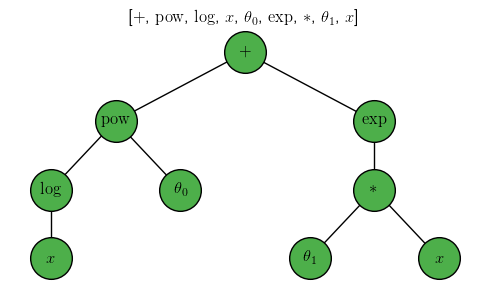

In [11]:
rcParams['text.usetex'] = True

def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.
    Licensed under Creative Commons Attribution-Share Alike
    
    If the graph is a tree this will return the positions to plot this in a
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch
    - if the tree is directed and this is not given,
      the root will be found and used
    - if the tree is directed and this is given, then
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given,
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)
        if len(children)!=0:
            dx = width/len(children)
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap,
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)
    
def make_tree(tree, i, names):
    
    tree[i].tree = treelib.Tree()
    
    # Check for duplicate node names
    if tree[i].op in names:
        n = [a for a in names if a.startswith(tree[i].op)]
        tree[i].node_name = tree[i].op + str(len(n))
    else:
        tree[i].node_name = tree[i].op
    
    # Name and label of node
    if tree[i].val is None:
        tree[i].tree.create_node(tree[i].op, tree[i].node_name)
    else:
        tree[i].tree.create_node(str(tree[i].val), tree[i].node_name)
        
    # Store node names
    n2 = names.copy()
    n2 += [tree[i].node_name]
    
    if tree[i].type > 0:
        tree = make_tree(tree, tree[i].left, n2)
        n2 += list(tree[tree[i].left].tree.nodes.keys())
        tree[i].tree.paste(tree[i].node_name, tree[tree[i].left].tree)
    if tree[i].type > 1:
        tree = make_tree(tree, tree[i].right, n2)
        n2 += list(tree[tree[i].right].tree.nodes.keys())
        tree[i].tree.paste(tree[i].node_name, tree[tree[i].right].tree)
        
    return tree   

basis_functions = [["x", "a"],  # type0
                ["square", "exp", "inv", "sqrt", "log"],  # type1
                ["+", "*", "-", "/", "pow"]]  # type2

labels = ["+", "pow", "log", "x", "a0", "exp", "*", "a1", "x"]
s = []

for l in labels:
    if l.lstrip("-").isdigit() or (l.startswith('a') and l[1:].isdigit()):
        s.append(0)
    else:
        for i in range(len(basis_functions)):
            if l in basis_functions[i]:
                s.append(i)
                
success, part_considered, tree = generator.check_tree(s)
fstr = generator.node_to_string(0, tree, labels)
max_param = max(1, len([a for a in labels if a.startswith('a')]))
fstr, fsym = simplifier.initial_sympify([fstr], max_param, verbose=False)
fsym = fsym[fstr[0]]

for i in range(len(tree)):
    tree[i].assign_op(labels[i])
    
make_tree(tree, 0, [])

G = nx.Graph()

# Add all nodes to graph
for n in list(tree[0].tree.nodes.keys()):
    G.add_node(n)

# Node labels
labs = {}
for k in tree[0].tree.nodes.keys():
    if k.startswith('a') and k[1:].isdigit():
        labs[k] = r'$\theta_{%s}$'%tree[0].tree.nodes[k].tag[1:]
    elif tree[0].tree.nodes[k].tag == 'x':
        labs[k] = r'$%s$'%tree[0].tree.nodes[k].tag
    elif '_' in k:
        i = k.index('_')
        labs[k] = r'${\rm %s\_%s}$'%(tree[0].tree.nodes[k].tag[:i], tree[0].tree.nodes[k].tag[i+1:])
    else:
        labs[k] = r'${\rm %s}$'%tree[0].tree.nodes[k].tag

# Add all edges to graph
if tree[0].tree.nodes:
    for n in tree[0].tree.expand_tree(mode=tree[0].tree.WIDTH):
        nid = tree[0].tree[n].identifier

        for c in tree[0].tree.children(nid):
            cid = c.identifier
            G.add_edge(nid, cid)

pos = hierarchy_pos(G, tree[0].tree.root)

cm = plt.get_cmap('Set1')

fig, ax = plt.subplots(1, 1, figsize=(5,3))
nx.draw(G, pos=pos,
        with_labels=True,
        labels=labs,
        node_size=900,
        node_color=cm(2),
        edgecolors='k')
t = [labs[a] for a in labels]
t = '[' + ', '.join(t) + ']'
t = r'%s'%t
ax.set_title(t)
fig.tight_layout()
fig.savefig('figs/tree.pdf', bbox_inches='tight', transparent=True)

# Figure 2 - Number of functions vs Complexity

167731333 1.68e+08
core_maths/
1
2
3
4
5
6
7
8
9
10
1 2 2 1.0
2 2 2 1.0
3 22 13 1.6923076923076923
4 64 24 2.6666666666666665
5 598 131 4.564885496183206
6 2406 335 7.182089552238806
7 19860 1787 11.11359820928931
8 99406 5458 18.212898497618177
9 763765 28464 26.832665823496345
10 4339761 98018 44.275143341018996
Total: 5225886 134234 38.93116498055634 1249.5443255807024
Total: 4865011 119861 40.58877366282611 1399.3820592185948


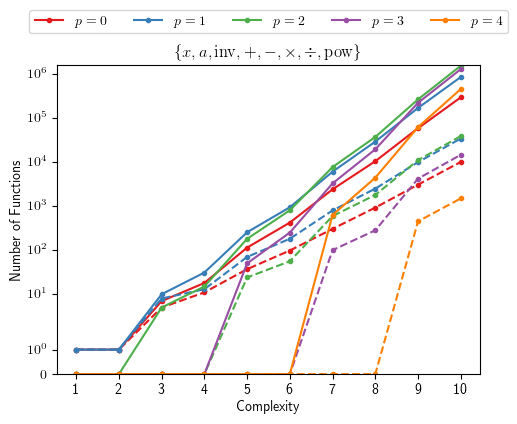

In [37]:
def file_len(fname):
    p = subprocess.Popen(['wc', '-l', fname], stdout=subprocess.PIPE,
                                              stderr=subprocess.PIPE)
    result, err = p.communicate()
    if p.returncode != 0:
        raise IOError(err)
    return int(result.strip().split()[0])


def count_fun(fname):

    ntotal = file_len(fname)
    with open(fname, "r") as f:
        all_fun = f.read().splitlines()
    assert ntotal == len(all_fun), 'Maybe missing some equations'
    max_param = simplifier.get_max_param(all_fun, verbose=False)
    nparam = simplifier.count_params(all_fun, max_param)
    count = np.empty(max_param + 1, dtype=int)
    for i in range(len(count)):
        count[i] = (nparam == i).sum()
    assert ntotal == count.sum(), 'Count does not match total'

    return count

all_compl = np.arange(1, 11)
# all_dirname = ['core_maths/', 'osc_maths/', 'ext_maths/']
# all_ops = [r'Core = $\{x, a, {\rm inv}, +, -, \times, \div, {\rm pow} \}$',
#           r'Core + $\{ \sin \}$',
#           r'Core + $\{ {\rm square}, \exp, \sqrt{\cdot} \}$']
all_dirname = ['core_maths/']
all_ops = [r'$\{x, a, {\rm inv}, +, -, \times, \div, {\rm pow} \}$']

basis_functions = [["x", "a"],  # type0
                    ["inv"],  # type1
                    ["+", "*", "-", "/", "pow"]]  # type2
nbasis = sum([len(b) for b in basis_functions])
nfun = sum([c ** nbasis for c in all_compl])
print(nfun, '%.2e'%nfun)

nfortab = 4

# fig, axs = plt.subplots(1, 3, figsize=(10,3), sharey=True)
fig, axs = plt.subplots(1, 1, figsize=(5,4))
axs = [axs]
cm = plt.get_cmap('Set1')

for i in range(len(all_dirname)):
    
    dirname = all_dirname[i]
    ops = all_ops[i]

    all_total = []
    all_uniq = []
    
    print(dirname)

    for compl in all_compl:

        print(compl)

        try:
            fname = dirname + '/compl_%i/all_equations_%i.txt'%(compl,compl)
            total_count = count_fun(fname)

            fname = dirname + '/compl_%i/unique_equations_%i.txt'%(compl,compl)
            uniq_count = count_fun(fname)

            if (len(uniq_count) < nfortab+1) or (len(total_count) < nfortab+1):
                t = np.zeros(nfortab+1, dtype=int)
                t[:len(uniq_count)] = uniq_count
                uniq_count = t

                t = np.zeros(nfortab+1, dtype=int)
                t[:len(total_count)] = total_count
                total_count = t

            all_total.append([x for x in total_count[:nfortab+1]])
            all_uniq.append([x for x in uniq_count[:nfortab+1]])

        except:
            pass

    all_total = np.array(all_total, dtype=int)
    all_uniq = np.array(all_uniq, dtype=int)
    
    for j in range(all_total.shape[1]):
        c = cm(j)
        axs[i].plot(all_compl[:all_total.shape[0]], all_total[:,j], color=c, marker='.', label=r'$p = %i$'%j)
        axs[i].plot(all_compl[:all_total.shape[0]], all_uniq[:,j], color=c, ls='--', marker='.')
        
    axs[i].set_xlabel('Complexity')
    axs[i].set_title(ops)
    
    axs[i].set_xticks(all_compl)
    axs[i].set_xticklabels(all_compl)
    
    for j, c in enumerate(all_compl[:all_total.shape[0]]):
        print(c, all_total[j].sum(), all_uniq[j].sum(), all_total[j].sum() / all_uniq[j].sum())
    print('Total:', all_total.sum(), all_uniq.sum(), all_total.sum() / all_uniq.sum(), nfun / all_uniq.sum())
    total_with_param = all_total[:,1:].sum()
    uniq_with_param = all_uniq[:,1:].sum()
    print('Total with param:', total_with_param, uniq_with_param, total_with_param / uniq_with_param, nfun / uniq_with_param)
    
axs[0].set_yscale('symlog')
axs[0].set_ylabel('Number of Functions')
axs[0].set_ylim(0, None)

fig.tight_layout()
fig.subplots_adjust(hspace=0)

# axs[int(np.floor(len(axs)/2))].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=nfortab+1, fancybox=True)
axs[int(np.floor(len(axs)/2))].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=nfortab+1, fancybox=True)
fig.savefig('figs/count_functions.pdf', bbox_inches='tight', transparent=True)

# Figures 3&4 - Data Comparison

In [ ]:
def data_comparison(likelihood, nfun, ylabel1, ylabel2, savename):

    xplot = np.logspace(np.log10(6e-2), np.log10(2.1), 1000) + 1
    tmax = 5

    # GET LCDM FUNCTION
    fcn_i = 'a0 * pow(x, 3) + a1'
    fcn_i, eq, integrated = likelihood.run_sympify(fcn_i, tmax=tmax, try_integration=False)

    if 'a3' in fcn_i:
        k = 4
        eq_numpy = sympy.lambdify([x, a0, a1, a2, a3], eq, modules=["numpy","sympy"])
    elif 'a2' in fcn_i:
        k = 3
        eq_numpy = sympy.lambdify([x, a0, a1, a2], eq, modules=["numpy","sympy"])
    elif 'a1' in fcn_i:
        k = 2
        eq_numpy = sympy.lambdify([x, a0, a1], eq, modules=["numpy","sympy"])
    elif 'a0' in fcn_i:
        k = 1
        eq_numpy = sympy.lambdify([x, a0], eq, modules=["numpy","sympy"])
    else:
        k = 0
        eq_numpy = sympy.lambdify([x], eq, modules=["numpy","sympy"])

    chi2, p = test_all.optimise_fun(fcn_i, likelihood, tmax, 0, 4, try_integration=False)
    print(chi2, p)

    likelihood.clear_data()
    ylcdm_var = likelihood.get_pred(likelihood.xvar, p[:k], eq_numpy, integrated=integrated)
    likelihood.clear_data()
    ylcdm_plot = likelihood.get_pred(xplot, p[:k], eq_numpy, integrated=integrated)

    # GET OTHER FUNCTIONS
    all_compl = np.arange(3, 9)
    fcn_list = []
    all_DL = []
    params = []

    for i, compl in enumerate(all_compl):
        fname = likelihood.out_dir + '/final_%i.dat'%compl
        with open(fname, "r") as f:
            reader = csv.reader(f, delimiter=';')
            data = [row for row in reader]
        fcn_list += [d[1] for d in data]
        all_DL += [d[2] for d in data]
        params += [d[7:] for d in data]

    all_DL = np.array(all_DL, dtype=float)
    params = np.array(params, dtype=float)
    m = np.isfinite(all_DL)
    all_DL = all_DL[m]
    params = params[m,:]
    fcn_list = [fcn_list[i] for i in range(len(fcn_list)) if m[i]]
    MDL = np.amin(all_DL)

    # Take top nfun functions
    idx = np.argsort(all_DL)[:min(nfun, len(all_DL))]
    all_DL = all_DL[idx] - MDL
    params = params[idx,:]
    fcn_list = [fcn_list[i] for i in idx]

    fig  = plt.figure(figsize=(5,4))
    ax1  = fig.add_axes([0.0,0.50,0.9,0.45])
    ax2  = fig.add_axes([0.0,0.0,0.9,0.45])
    ax3  = fig.add_axes([0.95,0.00,0.03,0.95])
    ax1.get_shared_x_axes().join(ax1, ax2)

    cmap = cm.hot
    vmin = all_DL.min()
    vmax = all_DL.max()
    norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
    print(vmin, vmax)

    max_param = 4
    tmax = 5
    
    likelihood.clear_data()
    
    for i in range(len(fcn_list)):

        fcn_i = fcn_list[i].replace('\'', '')

        k = simplifier.count_params([fcn_i], max_param)[0]
        measured = params[i,:k]
        
        if i%10 == 0:
            print('%i of %i'%(i,len(fcn_list)))

        try:
            fcn_i, eq, integrated = likelihood.run_sympify(fcn_i, tmax=tmax)
            if k == 0:
                eq_numpy = sympy.lambdify([x], eq, modules=["numpy","sympy"])
            elif k==1:
                eq_numpy = sympy.lambdify([x, a0], eq, modules=["numpy","sympy"])
            elif k==2:
                eq_numpy = sympy.lambdify([x, a0, a1], eq, modules=["numpy","sympy"])
            elif k==3:
                eq_numpy = sympy.lambdify([x, a0, a1, a2], eq, modules=["numpy","sympy"])
            elif k==4:
                eq_numpy = sympy.lambdify([x, a0, a1, a2, a3], eq, modules=["numpy","sympy"])
            ypred_plot = likelihood.get_pred(xplot, measured, eq_numpy, integrated=integrated)
        except:
            fcn_i, eq, integrated = run_sympify(fcn_i, tmax=tmax, try_integration=False)
            if k == 0:
                eq_numpy = sympy.lambdify([x], eq, modules=["numpy","sympy"])
            elif k==1:
                eq_numpy = sympy.lambdify([x, a0], eq, modules=["numpy","sympy"])
            elif k==2:
                eq_numpy = sympy.lambdify([x, a0, a1], eq, modules=["numpy","sympy"])
            elif k==3:
                eq_numpy = sympy.lambdify([x, a0, a1, a2], eq, modules=["numpy","sympy"])
            elif k==4:
                eq_numpy = sympy.lambdify([x, a0, a1, a2, a3], eq, modules=["numpy","sympy"])
            ypred_plot = likelihood.get_pred(xplot, measured, eq_numpy, integrated=integrated)

        colour = cmap(norm(all_DL[i]))
        plot_kwargs = {'color':colour, 'zorder':len(fcn_list)-i, 'lw':1}

        ax1.plot(xplot-1, ypred_plot, **plot_kwargs)
        ax2.plot(xplot-1, ypred_plot-ylcdm_plot, **plot_kwargs)

    cmvar = plt.get_cmap('Set1')
    plot_kwargs = {'fmt':'.', 'markersize':1, 'zorder':-1, 
                 'capsize':1, 'elinewidth':0.5, 'color':cmvar(1), 'alpha':1}

    ax1.errorbar(likelihood.xvar-1, likelihood.yvar, yerr=likelihood.yerr, **plot_kwargs)
    ax2.errorbar(likelihood.xvar-1, likelihood.yvar-ylcdm_var, yerr=likelihood.yerr, **plot_kwargs)
    ax2.axhline(y=0, color=cmvar(1), ls='--')

    ax2.set_xlabel(r'$z$')
    ax1.set_ylabel(ylabel1)
    ax2.set_ylabel(ylabel2)

    ax1.set_xlim(xplot.min()-1, xplot.max()-1)
    ax1.set_xscale('log')
    ax1.set_xticklabels([])

    cb1 = mpl.colorbar.ColorbarBase(ax3,cmap=cmap,norm=norm,orientation='vertical')
    cb1.set_label(r'$L \left( D \right) - MDL$')

    fig.align_ylabels([ax1, ax2])
    fig.tight_layout()

    ax1.get_yaxis().set_label_coords(-0.08,0.5)
    ax2.get_yaxis().set_label_coords(-0.08,0.5)

    fig.savefig(savename, bbox_inches='tight', transparent=True)
    
    return

data_comparison(cc_like, 
                100, 
                r'$H \left( z \right) \ / \ H_0$', 
                r'$\left( H \left( z \right) - H_{\rm \Lambda CDM} \left( z \right) \right) \ / \ H_0$', 
                'figs/cc_prediction.pdf')

data_comparison(panth_like, 
                10, 
                r'$\mu \left( z \right)$', 
                r'$\mu \left( z \right) - \mu_{\rm \Lambda CDM} \left( z \right)$', 
                'figs/pantheon_prediction.pdf')


# Figure 4 - Pareto Front Comparison 

In [ ]:
root_dirname = '/mnt/zfsusers/deaglan/symbolic_regression/brute_force/simplify_brute/Pantheon/'

all_dirname = ['output_panth/', 'output_cc/']
all_ls = ['-', '--']
line_labels = ['Pantheon+SH0ES', "Cosmic Chronometers"]

# all_dirname = ['output_cc/']
# all_ls = ['-']
# line_labels = ["Cosmic Chronometers"]

all_compl = np.arange(3, 9)
               
fig, ax1 = plt.subplots(1, 1, figsize=(5,3))
ax2 = ax1.twinx()
cm = plt.get_cmap('Set1')
               
for k in range(len(all_dirname)):
               
    dirname = root_dirname + all_dirname[k]
    print(dirname)
               
    DL = np.empty(len(all_compl))
    logL = np.empty(len(all_compl))
    DL_fun = [None] * len(all_compl)
    logL_fun = [None] * len(all_compl)

    for i, compl in enumerate(all_compl):
        fname = dirname + 'final_%i.dat'%compl
        with open(fname, "r") as f:
            reader = csv.reader(f, delimiter=';')
            data = [row for row in reader]
            ll = np.array([d[4] for d in data], dtype=float)
            j = np.nanargmin(ll)
            logL[i] = ll[j]
            logL_fun[i] = [data[j][1], data[j][7:]]

        DL[i] = data[0][2]
        DL_fun[i] = [data[0][1], data[0][7:]]

    print('BEST FUNCTION (MDL):', DL_fun[np.argmin(DL)])
    print('BEST FUNCTION (logL):', logL_fun[np.argmin(logL)])
    
    DL -= np.amin(DL)
    logL -= np.amin(logL)

    ax1.plot(all_compl, DL, marker='.', color=cm(0), ls=all_ls[k])
    ax2.plot(all_compl, logL, marker='.', color=cm(1), ls=all_ls[k])
    

ax1.set_ylabel(r'$L \left( D \right)$')
ax1.set_xticks(all_compl)
ax1.set_xticklabels(all_compl);
ax1.set_xlabel(r'Complexity')
               
ax2.set_ylabel(r'$ - \log\mathcal{L}$')
ax1.yaxis.label.set_color(cm(0))
ax1.tick_params(axis='y', colors=cm(0))
ax2.spines['left'].set_color(cm(0))

ax2.yaxis.label.set_color(cm(1))
ax2.tick_params(axis='y', colors=cm(1))
ax2.spines['right'].set_color(cm(1))

custom_lines = []
for i in range(len(all_ls)):
    custom_lines.append(Line2D([0], [0], color='k', lw=1, ls=all_ls[i]))
    
ax1.legend(custom_lines, line_labels, fancybox=True)
ax1.set_yscale('symlog', linthresh=1)
ax1.set_ylim(0, None)
ax2.set_yscale('symlog', linthresh=1)
ax2.set_ylim(0, None)
                
fig.tight_layout()
    

# Tabulate the Best Functions

In [38]:
root_dirname = '/mnt/zfsusers/deaglan/symbolic_regression/brute_force/simplify_brute/Pantheon/'
all_dirname = ['output_panth/', 'output_cc/']
all_dirname = [root_dirname + d for d in all_dirname]
all_compl = np.arange(3, 9)

Run this step by eye first to identify a Friedmann-like equation

In [20]:
for dirname in all_dirname:
    print('\n', dirname)
    fun = []
    DL = []
    for i, compl in enumerate(all_compl):
        fname = dirname + 'final_%i.dat'%compl
        with open(fname, "r") as f:
            reader = csv.reader(f, delimiter=';')
            data = [row for row in reader]
            fun += [d[1] for d in data]
            DL += [d[2] for d in data]
    
    DL = np.array(DL, dtype=float)
    
    # Sort by DL
    m = np.argsort(DL)
    DL = DL[m]
    fun = [fun[i] for i in m]
            
    # Find best Friedmann-like equation
    cand = [f for f in fun if 'a2' in f and 'a3' not in f]
    cand = [f for f in cand if f.count('pow') == 1 and 'pow(x,' in f]
    for i in range(10):
        print(cand[i])


 /mnt/zfsusers/deaglan/symbolic_regression/brute_force/simplify_brute/Pantheon/output_panth/
a0*(a1 + pow(x,a2))
a0/(a1 + pow(x,a2))
a0 - 1/(a1 - pow(x,a2))
(a1 + pow(x,a2))/a0
1/(a0*(a1 + pow(x,a2)))
a0*(a1 - pow(x,a2))
-a2 + 1/(a0 - pow(x,a1))
a0 - 1/(-a2 + pow(x,a1))
1/(a0*(a1 - pow(x,a2)))
a0*a1*pow(x,a2)

 /mnt/zfsusers/deaglan/symbolic_regression/brute_force/simplify_brute/Pantheon/output_cc/
a0 + a1*pow(x,a2)
a0*(a1 + pow(x,a2))
a0/(a1 - pow(x,a2))
a0 - 1/(a1 - pow(x,a2))
a0 + 1/(a1*pow(x,a2))
(a1 + pow(x,a2))/a0
1/(a0*(a1 + pow(x,a2)))
1/(a0 + a1*pow(x,a2))
1/(a0*(a1 - pow(x,a2)))
-a2 + 1/(a0 - pow(x,a1))


In [39]:
all_lcdm_eq = ['a0*(a1 + pow(x,a2))', 'a0*(a1 + pow(x,a2))']

In [43]:
nrow = 5
npcol = 3

def get_str(i):
    
    fcn_i = fun[i]
    fcn_i = fcn_i.replace('\n', '')
    fcn_i = fcn_i.replace('\'', '')

    eq = sympy.sympify(fcn_i,
                    locals={"inv": inv,
                            "square": square,
                            "cube": cube,
                            "sqrt": sqrt,
                            "log": log,
                            "pow": pow,
                            "x": x,
                            "a0": a0,
                            "a1": a1,
                            "a2": a2})
    f = texprinter.doprint(eq)
    f = '$' + f.replace('a_', '\\theta_') + '$'

    if 'a3' in fcn_i:
        npar = 4
    elif 'a2' in fcn_i:
        npar = 3
    elif 'a1' in fcn_i:
        npar = 2
    elif 'a0' in fcn_i:
        npar = 1
    else:
        npar = 0
        
    if npar > npcol:
        print('NOT ENOUGH COLUMSN FOR NUMBER OF PARAMETERS')

    s = ''
    for j in range(len(params[i,:])):
        if j < npar:
            s += '%.2f & '%params[i,j]
        else:
            s += '- & '
    s = s[:-2]
#     s = '\t\t\t%i & %s & %.2f & %.2f & %s \\\\'%(i+1, f, DL[i], logL[i], s)
    s = '\t\t\t%i & %s & %i & %.2f & %s \\\\'%(i+1, f, store_comp[i], DL[i], s)
    
    return s


for dirname in all_dirname:
    
    print(dirname)
    lcdm_eq = all_lcdm_eq[all_dirname.index(dirname)]
    
    all_compl = np.arange(3, 9)

    DL = []
    logL = []
    fun = []
    params = []
    store_comp = []
    
    for i, compl in enumerate(all_compl):
        fname = dirname + 'final_%i.dat'%compl
        with open(fname, "r") as f:
            reader = csv.reader(f, delimiter=';')
            data = [row for row in reader]

            DL += [d[2] for d in data]
            logL += [d[4] for d in data]
            fun += [d[1] for d in data]
            params += [d[7:] for d in data]
            store_comp += [compl] * len(data)

    DL = np.array(DL, dtype=float)
    logL = np.array(logL, dtype=float)
    params = np.array(params, dtype=float)
    store_comp = np.array(store_comp, dtype=int)
    
    params = params[:,:npcol]

    # Sort by DL
    m = np.argsort(DL)
    DL = DL[m]
    logL = logL[m]
    params = params[m,:]
    store_comp = store_comp[m]
    fun = [fun[i] for i in m]

    lcdm_idx = fun.index(lcdm_eq)
    
    texprinter = LatexPrinter()

    form = 'c|c|c|c'
#     labs = 'Rank & Function & $L\\left(D\\right)$ & $-\\log\\mathcal{L}$'
    labs = 'Rank & Function & Complexity & $L\\left(D\\right)$'
    for i in range(params.shape[1]):
        form += '|c'
        labs += ' & $\\theta_{%i}$'%i
    labs += '\\\\'

    print('\t\t\\begin{tabular}{%s}'%form)
    print('\t\t\\hline')
    print('\t\t' + labs)
    print('\t\t\\hline')

    for i in range(nrow):
        s = get_str(i)
        print(s)
    
    if lcdm_idx >= nrow:

        if lcdm_idx > nrow:
            filler = '\\vdots & \\vdots & \\vdots & \\vdots'
            for i in range(params.shape[1]):
                filler += ' & \\vdots'
            filler += ' \\\\'
            print(filler)

        s = get_str(lcdm_idx)
        print(s)

    print('\t\t\\hline') 
    print('\t\t\\end{tabular}')

    print('\n\n')


/mnt/zfsusers/deaglan/symbolic_regression/brute_force/simplify_brute/Pantheon/output_panth/
		\begin{tabular}{c|c|c|c|c|c|c}
		\hline
		Rank & Function & Complexity & $L\left(D\right)$ & $\theta_{0}$ & $\theta_{1}$ & $\theta_{2}$\\
		\hline
			1 & $\theta_{0} + x^{x}$ & 5 & 716.48 & 0.20 & - & -  \\
			2 & $\left|{\theta_{0} + x}\right|^{x}$ & 5 & 716.59 & 0.18 & - & -  \\
			3 & $x \left|{\theta_{0}}\right|^{x^{2}}$ & 7 & 717.81 & 1.16 & - & -  \\
			4 & $\left|{\theta_{0} + x}\right|^{x^{\theta_{1}}}$ & 7 & 717.84 & 0.18 & 0.82 & -  \\
			5 & $\theta_{0} x^{x}$ & 5 & 718.22 & 1.18 & - & -  \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
			256 & $\theta_{0} \left(\theta_{1} + x^{\theta_{2}}\right)$ & 7 & 725.90 & 0.46 & 1.59 & 2.73  \\
		\hline
		\end{tabular}



/mnt/zfsusers/deaglan/symbolic_regression/brute_force/simplify_brute/Pantheon/output_cc/
		\begin{tabular}{c|c|c|c|c|c|c}
		\hline
		Rank & Function & Complexity & $L\left(D\right)$ & $\theta_{0}$ & $\thet